In [1]:
using Rocket, ReactiveMP, GraphPPL, Distributions

We assume that we don't know the shape of our signal in advance. So we try to fit a simple gaussian random walk with unknown observation noise:

In [2]:
@model function kalman_filter()
    
    # Reactive inputs
    x_t_min_mean = datavar(Float64)
    x_t_min_var  = datavar(Float64)
    τ_shape = datavar(Float64)
    τ_rate  = datavar(Float64)

    τ ~ GammaShapeRate(τ_shape, τ_rate)
    
    x_t_min ~ NormalMeanVariance(x_t_min_mean, x_t_min_var)
    x_t     ~ NormalMeanPrecision(x_t_min, 1.0)
    
    y = datavar(Float64)
    y ~ NormalMeanPrecision(x_t, τ)
    
end

@constraints function filter_constraints()
    q(x_t, τ) = q(x_t)q(τ)
end

filter_constraints (generic function with 1 method)

In [3]:
function start_inference(data_stream)
     
    model, _ = kalman_filter(filter_constraints())
    
    x_t_min_prior = NormalMeanVariance(0.0, 1e7)
    τ_prior       = GammaShapeRate(1.0, 1.0)
    
    x_t_stream = Subject(Marginal)
    τ_stream   = Subject(Marginal)
    
    main = combineLatest((
        getmarginal(model[:x_t], IncludeAll()), 
        getmarginal(model[:τ], IncludeAll()), 
        data_stream
    ), PushNew())
    
    save_scheduler = PendingScheduler()
    
    vmp_iterations = 5
    
    subscription = subscribe!(main, (d) -> begin
        x_t_next_prior = d[1]
        τ_next_prior   = d[2]
        observation    = d[3]
        
        for i in 1:vmp_iterations
            update!(model[:x_t_min_mean], mean(x_t_next_prior))
            update!(model[:x_t_min_var], var(x_t_next_prior))
            update!(model[:τ_shape], shape(τ_next_prior))
            update!(model[:τ_rate], rate(τ_next_prior))
            update!(model[:y], observation)
        end
            
        release!(save_scheduler)
    end)
    
    save = combineLatest((
        getmarginal(model[:x_t], IncludeAll()), 
        getmarginal(model[:τ], IncludeAll()),
    ), PushEach()) |> schedule_on(save_scheduler)
    
    save_subscribtion = subscribe!(save, (posteriors) -> begin
        next!(x_t_stream, posteriors[1])
        next!(τ_stream, posteriors[2])
    end)
    
    setmarginal!(model[:x_t], x_t_min_prior)
    setmarginal!(model[:τ], τ_prior)
    
    return x_t_stream, τ_stream, () -> begin
        unsubscribe!(save_subscribtion)
        unsubscribe!(subscription)
    end
end

start_inference (generic function with 1 method)

In [4]:
mutable struct DataGenerationProcess
    previous :: Float64
    process_noise :: Float64
    observation_noise :: Float64
    history :: Vector{Float64}
    observations :: Vector{Float64}
end

function getnext!(process::DataGenerationProcess)
    process.previous = process.previous + 1.0
    next = 10sin(0.1 * process.previous)
    observation = next + rand(Normal(0.0, process.observation_noise))
    push!(process.history, next)
    push!(process.observations, observation)
    return observation
end

function gethistory(process::DataGenerationProcess)
    return process.history
end

function getobservations(process::DataGenerationProcess)
    return process.observations
end

getobservations (generic function with 1 method)

In [5]:
using Plots

In [6]:
# We force stop after n data points
n = 150

150

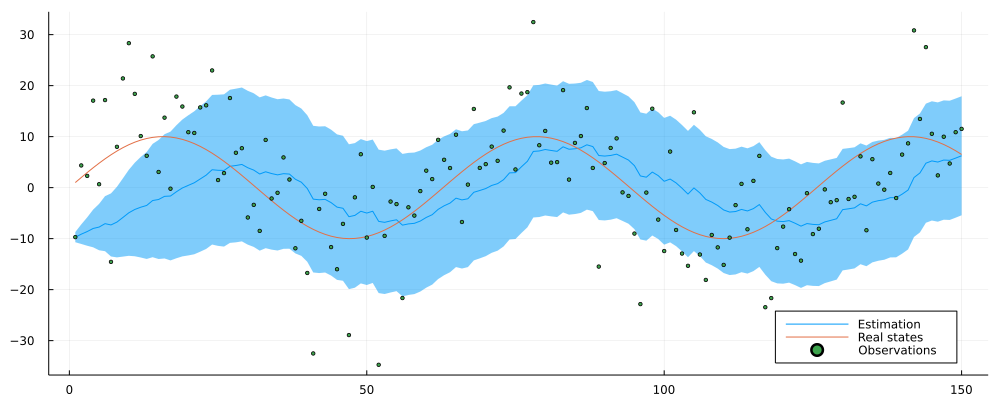

In [7]:
process = DataGenerationProcess(0.0, 1.0, 10.0, Float64[], Float64[])
stream = timer(100, 100) |> map_to(process) |> map(Float64, getnext!) |> take(n)

x_t_stream, τ_stream, stop_cb = start_inference(stream);

plot_callback = (posteriors) -> begin
    IJulia.clear_output(true)
    
    p = plot(mean.(posteriors), ribbon = var.(posteriors), label = "Estimation")
    p = plot!(gethistory(process), label = "Real states")    
    p = scatter!(getobservations(process), ms = 2, label = "Observations")
    p = plot(p, size = (1000, 400), legend = :bottomright)
        
    display(p)
end

# First plot in Julia takes some extra time, wait at least a minute for a first plot to showup
sub = subscribe!(x_t_stream |> scan(Vector{Marginal}, vcat, Marginal[]) |> map(Vector{Marginal}, reverse), lambda(
    on_next  = plot_callback,
    on_error = (e) -> println(e)
))

In [8]:
stop_cb()
IJulia.clear_output(false);